In [15]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

#### RGB to HSV
Convert RGB image to HSV color space<br>
rgb_image: input RGB image (height, width, 3)<br>
h_out: output Hue channel (height, width) - ranges from 0 to 360<br>
s_out: output Saturation channel (height, width) - ranges from 0 to 1<br>
v_out: output Value channel (height, width) - ranges from 0 to 1<br>
<br>
<b>Hue, Saturation, Value</b><br>
• H ∈[0..360] : "The color"<br>
0° or 360° = Red<br>
60° = Yellow<br>
120° = Green<br>
180° = Cyan<br>
240° = Blue<br>
300° = Magenta<br>
• S ∈[0..1]: “The colorfulness”<br>
0.0 = Gray (no color)<br>
1.0 = Full color intensity<br>
• V ∈[0..1]: “The brightness”<br>
0.0 = Black<br>
1.0 = Full brightness<br>

In [16]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def RGB2HSV(rgb_in, h_out, s_out, v_out):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx < rgb_in.shape[1] and tidy < rgb_in.shape[0]:
        # Preparation
        ## Scale R, G, B to [0..255] to [0..1]
        r = rgb_in[tidy, tidx, 0] / 255.0
        g = rgb_in[tidy, tidx, 1] / 255.0
        b = rgb_in[tidy, tidx, 2] / 255.0
        ## Find max and min among R, G, B ∈[0..1]
        cmax = max(r, max(g, b))
        cmin = min(r, min(g, b))
        ## ∆ = max−min
        diff = cmax - cmin
        
        # Calculate Hue
        if diff == 0: h = 0
        if cmax == r: h = (60 * ((g - b) / diff) % 6) 
        if cmax == g: h = (60 * ((b - r) / diff) + 2)
        if cmax == b: h = (60 * ((r - g) / diff) + 4)
        # Calculate Saturation
        s = 0 if cmax == 0 else (diff / cmax)
        # Calculate Value
        v = cmax
        
        # Scatter the results to separate arrays
        h_out[tidy, tidx] = h
        s_out[tidy, tidx] = s
        v_out[tidy, tidx] = v


def convert_rgb_to_hsv(rgb_image):
    # Create output arrays
    height= rgb_image.shape[0]
    width = rgb_image.shape[1]
    h_out = np.zeros((height, width), dtype=np.float32)
    s_out = np.zeros((height, width), dtype=np.float32)
    v_out = np.zeros((height, width), dtype=np.float32)
    
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h_out)
    d_s = cuda.to_device(s_out)
    d_v = cuda.to_device(v_out)
    
    # CPU set up grid and block dimensions
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # GPU launch kernel
    RGB2HSV[grid_dim, block_dim](d_rgb, d_h, d_s, d_v)
    
    # GPU to CPU
    h_out = d_h.copy_to_host()
    s_out = d_s.copy_to_host()
    v_out = d_v.copy_to_host()
    
    return h_out, s_out, v_out

# Usage
# image = plt.imread("image1.jpg")
# h, s, v =convert_rgb_to_hsv(image)
# print(f"Hue:", h)
# print(f"Saturation:", s)
# print(f"Value:", v)

#### HSV to RGB

In [17]:
@cuda.jit
def HSV2RGB(h_in, s_in, v_in, rgb_out):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    if tidx < rgb_out.shape[1] and tidy < rgb_out.shape[0]:
        h = h_in[tidy, tidx]
        s = s_in[tidy, tidx]
        v = v_in[tidy, tidx]
        
        # Preparation
        d = h / 60.0
        h_i = int(d) % 6
        f = d - int(d)
        l = v * (1.0 - s)
        m = v * (1.0 - f * s)
        n = v * (1.0 - (1.0 - f) * s)
        
        # Conversion
        r, g, b = 0.0, 0.0, 0.0
        if 0 <= h < 60: r, g, b = v, n, l
        elif 60 <= h < 120: r, g, b = m, v, l
        elif 120 <= h < 180: r, g, b = l, v, n
        elif 180 <= h < 240: r, g, b = l, m, v
        elif 240 <= h < 300: r, g, b = n, l, v
        elif 300 <= h < 360: r, g, b = v, l, m
            
        # Scale to 0-255 range and store in output
        rgb_out[tidy, tidx, 0] = int(r * 255)
        rgb_out[tidy, tidx, 1] = int(g * 255)
        rgb_out[tidy, tidx, 2] = int(b * 255)

def convert_hsv_to_rgb(h, s, v):
    # Create output array
    height= h.shape[0]
    width = h.shape[1]
    rgb_out = np.zeros((height, width, 3), dtype=np.uint8)
    
    # CPU to GPU
    d_h = cuda.to_device(h)
    d_s = cuda.to_device(s)
    d_v = cuda.to_device(v)
    d_rgb = cuda.to_device(rgb_out)
    
    # CPU ask GPU
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # GPU launch kernel
    HSV2RGB[grid_dim, block_dim](d_h, d_s, d_v, d_rgb)
    
    # GPU to CPU
    rgb_out = d_rgb.copy_to_host()
    return rgb_out


# Usage
# reconstructed_rgb = convert_hsv_to_rgb(h,s,v)
# print(reconstructed_rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16111112..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..1235].


Converting RGB to HSV...
Hue: [[5.3114753 5.3114753 5.3114753 ... 4.4745765 1.1612903 2.6666667]
 [5.3114753 5.3114753 5.3114753 ... 4.4745765 1.1612903 2.6666667]
 [5.3114753 5.3114753 5.3114753 ... 4.4745765 1.1612903 2.6666667]
 ...
 [1.5789474 1.5789474 1.5789474 ... 0.        0.        0.       ]
 [4.5       4.5       4.5       ... 4.        4.        4.       ]
 [4.5       4.5       4.5       ... 4.        4.        4.       ]]
Saturation: [[0.7176471  0.7218935  0.7305389  ... 0.5412844  0.54385966 0.5478261 ]
 [0.7176471  0.7218935  0.7305389  ... 0.5412844  0.54385966 0.5478261 ]
 [0.7218935  0.72619045 0.7305389  ... 0.5412844  0.54385966 0.5478261 ]
 ...
 [0.1948718  0.19791667 0.19895288 ... 0.05970149 0.05970149 0.05970149]
 [0.2        0.20304568 0.20304568 ... 0.07389162 0.07389162 0.07389162]
 [0.19323671 0.19607843 0.19607843 ... 0.07352941 0.07352941 0.07389162]]
value [[0.6666667  0.6627451  0.654902   ... 0.42745098 0.44705883 0.4509804 ]
 [0.6666667  0.6627451  0.6

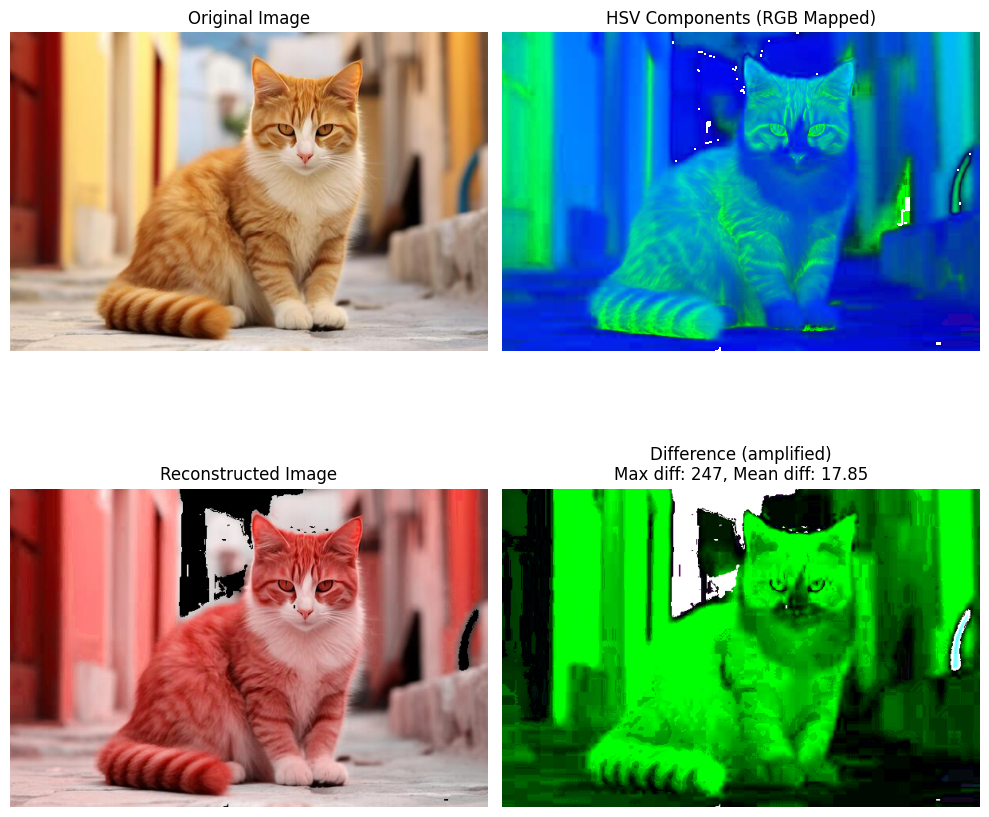


Conversion Statistics:
Maximum pixel difference: 247
Mean pixel difference: 17.85

HSV Ranges:
Hue range: nan° to nan°
Saturation range: 0.000 to 1.000
Value range: 0.000 to 1.000

Validity Checks:
Invalid Hue values (not 0-360): 9844
Invalid Saturation values (not 0-1): 0
Invalid Value values (not 0-1): 0


In [19]:
original = plt.imread("image1.jpg")
# Convert RGB to HSV
print("Converting RGB to HSV...")
h, s, v = convert_rgb_to_hsv(original)
print("Hue:",h)
print("Saturation:",s)
print("value",v)
    
# Convert back to RGB
print("Converting HSV back to RGB...")
reconstructed = convert_hsv_to_rgb(h, s, v)
    
# Calculate difference between original and reconstructed
diff = np.abs(original.astype(np.int32) - reconstructed.astype(np.int32))
max_diff = np.max(diff)
mean_diff = np.mean(diff)
    
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
# Original image visualization
axes[0, 0].imshow(original)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
    
# HSV visualization
hsv_vis = np.stack([
    h/360.0,  # Normalize H to 0-1 for visualization
    s,
    v
], axis=-1)
axes[0, 1].imshow(hsv_vis)
axes[0, 1].set_title('HSV Components (RGB Mapped)')
axes[0, 1].axis('off')
    
# Reconstructed image
axes[1, 0].imshow(reconstructed)
axes[1, 0].set_title('Reconstructed Image')
axes[1, 0].axis('off')
    
# Difference image (amplified for visibility)
diff_vis = diff * 5  # Amplify differences for better visualization
axes[1, 1].imshow(diff_vis)
axes[1, 1].set_title(f'Difference (amplified)\nMax diff: {max_diff}, Mean diff: {mean_diff:.2f}')
axes[1, 1].axis('off')
    
plt.tight_layout()
plt.show()
    
# Print some statistics
print("\nConversion Statistics:")
print(f"Maximum pixel difference: {max_diff}")
print(f"Mean pixel difference: {mean_diff:.2f}")
    
# Print HSV ranges
print("\nHSV Ranges:")
print(f"Hue range: {h.min():.1f}° to {h.max():.1f}°")
print(f"Saturation range: {s.min():.3f} to {s.max():.3f}")
print(f"Value range: {v.min():.3f} to {v.max():.3f}")
    
# Check for any invalid values
print("\nValidity Checks:")
print(f"Invalid Hue values (not 0-360): {np.sum((h < 0) | (h > 360))}")
print(f"Invalid Saturation values (not 0-1): {np.sum((s < 0) | (s > 1))}")
print(f"Invalid Value values (not 0-1): {np.sum((v < 0) | (v > 1))}")